In [91]:
import pandas as pd
import numpy as np
import re
import os
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier

In [92]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_genderSub = pd.read_csv('gender_submission.csv')
full_data = [df_train, df_test]

In [66]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [67]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [68]:
df_genderSub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [69]:
df_survived = df_train[df_train['Survived'] == 1]

In [70]:
df_train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [71]:
df_train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [72]:
combine = [df_train, df_test]

In [73]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [74]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

df_train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


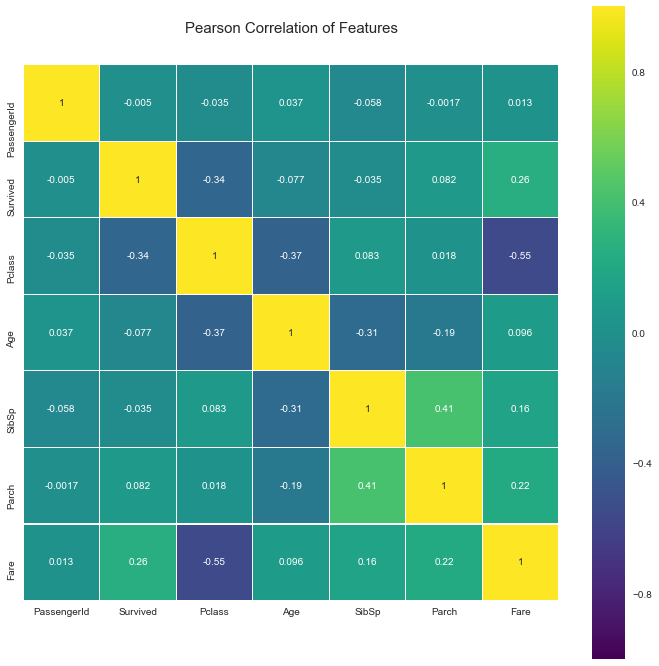

In [93]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_train.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [94]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
print (df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


In [95]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (df_train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


In [96]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
print (df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


In [97]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(df_train['Fare'].median())
df_train['CategoricalFare'] = pd.qcut(df_train['Fare'], 4)
print (df_train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

  CategoricalFare  Survived
0       [0, 7.91]  0.197309
1  (7.91, 14.454]  0.303571
2    (14.454, 31]  0.454955
3   (31, 512.329]  0.581081


In [98]:
for dataset in full_data:
    age_avg    = dataset['Age'].mean()
    age_std    = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
df_train['CategoricalAge'] = pd.cut(df_train['Age'], 5)

print (df_train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

  CategoricalAge  Survived
0    (-0.08, 16]  0.532710
1       (16, 32]  0.343750
2       (32, 48]  0.390625
3       (48, 64]  0.434783
4       (64, 80]  0.090909


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [99]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(df_train['Title'], df_train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [100]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
     'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (df_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


In [108]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch', 'FamilySize']
df_train = df_train.drop(drop_elements, axis = 1)
df_train = df_train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

df_test  = df_test.drop(drop_elements, axis = 1)

ValueError: labels ['PassengerId' 'Name' 'Ticket' 'Cabin' 'SibSp' 'Parch' 'FamilySize'] not contained in axis

In [102]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='gini', n_estimators=700, min_samples_split=10, min_samples_leaf=1,
                             max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

In [107]:
rf.fit(df_train.iloc[:, 1:], df_train.iloc[:, 0])
print("%.4f" % rf.oob_score_)

ValueError: could not convert string to float: 'Mr'

In [105]:
pd.concat((pd.DataFrame(df_train.iloc[:, 1:].columns, columns = ['Feature']), 
           pd.DataFrame(rf.feature_importances_, columns = ['Importance'])), 
          axis = 1).sort_values(by='Importance', ascending = False)[:20]

NotFittedError: Estimator not fitted, call `fit` before `feature_importances_`.

In [62]:
predictions = rf.predict(df_test)
predictions = pd.DataFrame(predictions, columns=['Survived'])
predictions = pd.concat((df_test, predictions), axis = 1)
predictions

,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title,Survived
0,3,1,2,0,2,1,1,0
1,3,0,2,0,0,0,3,0
2,2,1,3,1,2,1,1,0
3,3,1,1,1,0,1,1,0
4,3,0,1,1,0,0,3,1
5,3,1,0,1,0,1,1,0
6,3,0,1,0,2,1,2,1
7,2,1,1,2,0,0,1,0
8,3,0,1,0,1,1,3,1
9,3,1,1,2,0,0,1,0
